In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np

import sys
sys.path.append("/data/user/tchau/Software/charon")
sys.path.append("/data/user/tchau/Software/sympy-1.11.1-py3.10.egg")
sys.path.append("/data/user/tchau/Software/nuSQuIDS")
from charon import propa

from scipy import integrate
from python.Jfactor import *
from python.NuSpectra import *

import matplotlib.pyplot as plt

#Change the resolution of the plots
plt.rcParams['figure.dpi']= 150

# <font color="darkmagenta"> Dark Matter Signal flux computation in open angle </font>

In [3]:
# Computing differential/angular-integrated galactic DM flux

# return dN/(dE dOmega) [GeV-1 sr-1 cm-2 s-1] as 2D array in [psi, energy]
def GC_flux(mass, channel, profile, process, psi, E, tdecay=1e23, xsec=1e-23, type='PPPC4'):
    # Spectra
    Nu = NuSpectra(mass, channel, process)
    if "PPPC4" in type:
        spectra_dict = Nu.SpectraPPPC4_AvgOsc()
    elif "Charon" in type:
        spectra_dict = Nu.SpectraCharon_AvgOsc()

    if process=='ann':           
        Spectra = Interpolate_Spectra(spectra_dict, E, mass)
    elif process=='decay':
        Spectra = Interpolate_Spectra(spectra_dict, E, mass/2.)

    #Jfactor
    Jfactor_dict = Jfactor_Clumpy(profile, process)
    Jfactor = Interpolate_Jfactor(Jfactor_dict, psi)

    # Flux
    if process=='ann':
        factor = (1./(2 * 4*math.pi * mass**2))* xsec
    elif process=='decay':
        factor = (1./(4*math.pi * mass * tdecay))
    
    Flux = dict()
    for nu_type in Spectra.keys():
        Flux[nu_type] = np.array(Jfactor[:,None]* Spectra[nu_type])*factor

    return Flux

# Integrated flux from 0 to psi
def GC_flux_integrated(mass, channel, profile, process, Dpsi, E, tdecay=1e23, xsec=1e-24, type='PPPC4'):
    # Spectra
    Nu = NuSpectra(mass, channel, process)
    if "PPPC4" in type:
        spectra_dict = Nu.SpectraPPPC4_AvgOsc()
    elif "Charon" in type:
        spectra_dict = Nu.SpectraCharon_AvgOsc()

    if process=='ann':           
        Spectra = Interpolate_Spectra(spectra_dict, E, mass)
    elif process=='decay':
        Spectra = Interpolate_Spectra(spectra_dict, E, mass/2.)
    
    #Jfactor integrated
    psi = np.linspace(0, Dpsi, 10000)
    Jfactor_dict = Jfactor_Clumpy(profile, process)
    Jfactor = Interpolate_Jfactor(Jfactor_dict, psi)
    fint = Jfactor* 2*np.pi*np.sin(np.deg2rad(psi))
    Jfactor_int = integrate.trapz(fint, np.deg2rad(psi))
    # print(Jfactor_int)
    if process=='ann':
        factor = (1./(2 * 4*math.pi * mass**2))* xsec
    elif process=='decay':
        factor = (1./(4*math.pi * mass * tdecay))      
    Flux = dict()  
    for nutype in Spectra.keys():
        Flux[nutype] = factor* Spectra[nutype]* Jfactor_int
    return Flux


In [4]:
# extra galactic from Clumpy
curdir = os.getcwd()
process = 'decay'
mass = 1000
channel = 'bb'
extra_galactic = extract_values(f'{curdir}/resources/Clumpy_precomp/extra_galactic_flux/output_{process}/cosmo.{channel}_dPhidOmegadE_CIRELLI11_EW_NEUTRINO_m{mass}.ecsv', 0, 1)

<font color="darkmagenta"> ExtraGalactic vs Galactic </font>

In [5]:
ch_title = {"WW":r"$W^+ W^-$","bb":r"$b\bar{b}$","tautau":r"$\tau \bar{\tau}$", "mumu":r"$\mu^+\mu^-$","nuenue":r"$\nu_e \bar{\nu}_e$","numunumu":r'$\nu_\mu \bar{\nu}_\mu$',"nutaunutau":r"$\nu_\tau \bar{\nu}_\tau$"}

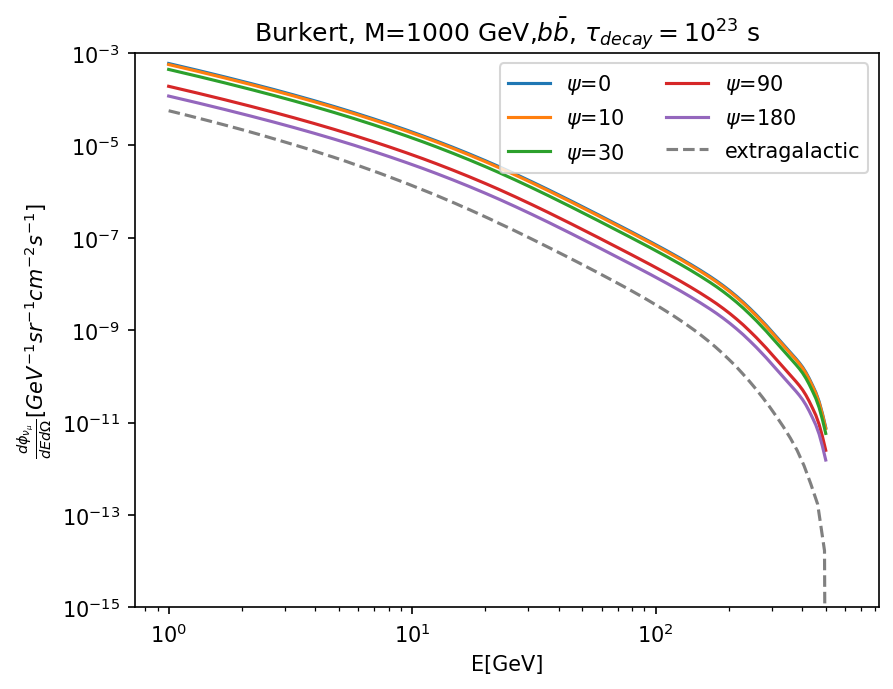

In [6]:
profile = 'Burkert'
mass=1000
channel = 'bb'

if process=='decay':
    E = np.logspace(0, np.log10(mass/2.), 200)
elif process=='ann':
    E = np.logspace(0, np.log10(mass), 200)

psi =np.array([0, 10, 30, 90, 180])

cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
RateGC = GC_flux(mass, channel, profile, process, psi, E)
for i, p in enumerate(psi):
    plt.plot(E, RateGC['nu_mu'][i][:], label=r'$\psi$={}'.format(p), color=cols[i])

plt.plot(extra_galactic[0], extra_galactic[1]/(extra_galactic[0]*extra_galactic[0]), label='extragalactic', ls='--', color='gray')

if process=='decay':
    plt.title(f"{profile}, "+ f"M={mass} GeV,"+ f"{ch_title[channel]}," r" $\tau_{decay}=10^{23}$ s")
elif process=='ann':
    plt.title(f"{profile}, "+ f"M={mass} GeV,"+ f" {ch_title[channel]}," r" $<\sigma v>=10^{-24} [cm^3 s^{-1}$]")

plt.semilogx()
plt.semilogy()
plt.ylabel(r"$\frac{d\phi_{\nu_\mu}}{dE d\Omega} [GeV^{-1} sr^{-1} cm^{-2} s^{-1}]$")
plt.xlabel('E[GeV]')

# plt.ylim(1e-10, 1e-3)
plt.ylim(1e-15, 1e-3)

plt.legend(ncol=2, loc='upper right')

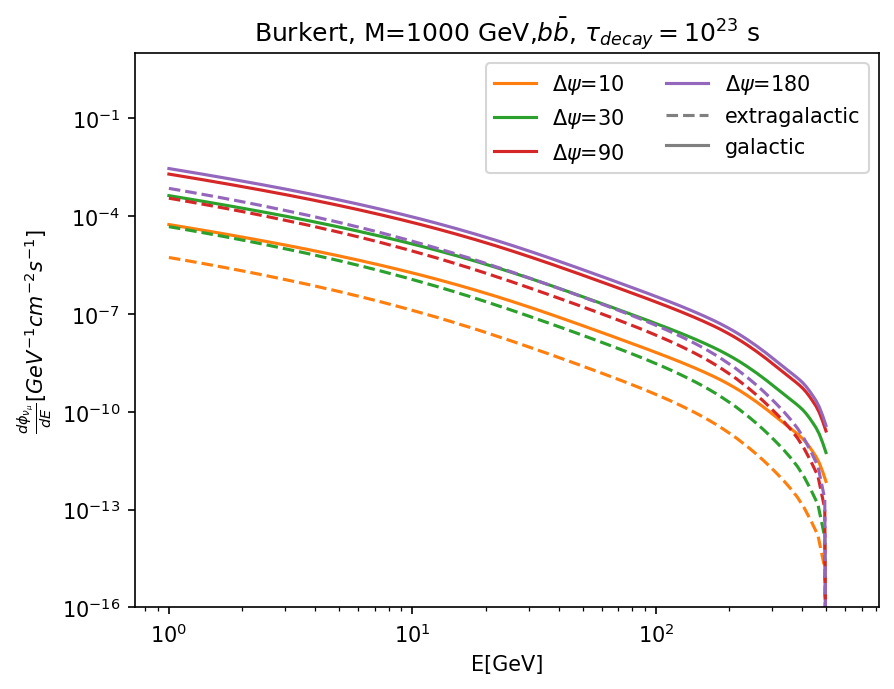

In [7]:
profile = 'Burkert'
mass=1000
channel = 'bb'

if process=='decay':
    E = np.logspace(0, np.log10(mass/2.), 200)
elif process=='ann':
    E = np.logspace(0, np.log10(mass), 200)

psi =np.array([10, 30, 90, 180])
cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i, p in enumerate(psi):
    RateGC = GC_flux_integrated(mass, channel, profile, process, p, E)
    plt.plot(E, RateGC['nu_mu'], label=r'$\Delta \psi$={}'.format(p), color=cols[i+1])
    plt.plot(extra_galactic[0],extra_galactic[1]/(extra_galactic[0]*extra_galactic[0])*  2*np.pi*(1-np.cos(np.deg2rad(p))), ls='--', color=cols[i+1])

if process=='decay':
    plt.title(f"{profile}, "+ f"M={mass} GeV,"+ f"{ch_title[channel]}," r" $\tau_{decay}=10^{23}$ s")
elif process=='ann':
    plt.title(f"{profile}, "+ f"M={mass} GeV,"+ f" {ch_title[channel]}," r" $<\sigma v>=10^{-24} [cm^3 s^{-1}$]")
    
plt.semilogx()
plt.semilogy()
plt.ylabel(r"$\frac{d\phi_{\nu_\mu}}{dE} [GeV^{-1} cm^{-2} s^{-1}]$")
plt.xlabel('E[GeV]')

# plt.ylim(1e-10, 1e-3)
plt.ylim(1e-16, 1e1)

plt.plot(0, 0, label='extragalactic', ls='--', color='gray')
plt.plot(0, 0, label='galactic', color='gray')
plt.legend(ncol=2, loc='upper right')

# Saving some flux of interest!

In [28]:
output = dict()
xsection = 1e-24
profile = "NFW"
channels = ['bb', 'tautau', 'numunumu']
masses = [63]

for channel in channels:
    for mass in masses:
        energies = np.logspace(0, np.log10(mass), 80)
        if channel=="numunumu":
            energies = np.linspace(1, mass, 80)
        RateGC = GC_flux_integrated(mass, channel, profile, "ann", 180, energies, xsec=xsection, type='Charon')
        output[f"{channel}"] = dict()
        output[f"{channel}"]["E"] = energies
        for nu in RateGC.keys():
            output[f"{channel}"][nu] = RateGC[nu]
output["xsection"] = xsection
output["flux_unit"] = "GeV^{-1} cm^{-2} s^{-1}"

Initial Flux Loading: /data/user/tchau/Software/charon/charon/data/Spectra_PYTHIA.hdf5
Initial Flux Loading: /data/user/tchau/Software/charon/charon/data/Spectra_PYTHIA.hdf5
Initial Flux Loading: /data/user/tchau/Software/charon/charon/data/Spectra_PYTHIA.hdf5


In [29]:
# save the output
import pickle as pkl
with open('/data/user/tchau/public_plots/IC93-GC_WIMP/GC_flux_M63GeV_annNFW.pkl', 'wb') as f:
    pkl.dump(output, f)